In [15]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import json

In [2]:
def poisson_disk_sampling(shapefile_path, radius, k=30):
    """
    Generate points within a polygon using Poisson Disk Sampling.

    Parameters:
    shapefile_path (str or GeoDataFrame): Path to the shapefile or a GeoDataFrame containing the polygons.
    radius (float): Minimum distance between points.
    k (int, optional): Number of attempts before rejection in the sampling process. Default is 30.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the generated points with the same CRS as the input shapefile.
    """

    def in_polygon(p, polygons):
        """Controlla se un punto è all'interno di uno dei poligoni."""
        point = Point(p[0], p[1])
        return any(polygon.contains(point) for polygon in polygons)

    def in_neighborhood(p, active_list, r):
        """Controlla se un punto è troppo vicino ad altri punti."""
        for q in active_list:
            if np.linalg.norm(np.array(p) - np.array(q)) < r:
                return True
        return False

    if isinstance(shapefile_path, str):
        geodf = gpd.read_file(shapefile_path)
    else:
        geodf = shapefile_path
    geodf = geodf.to_crs(epsg=3857)  # Proiezione Mercator
    # Estrarre i limiti rettangolari del GeoDataFrame
    bounds = geodf.total_bounds  # (xmin, ymin, xmax, ymax)
    polygons = geodf.geometry  # Lista di poligoni

    grid = {}
    active_list = []
    r = radius
    cell_size = r / np.sqrt(2)
    grid_width = int(np.ceil((bounds[2] - bounds[0]) / cell_size))
    grid_height = int(np.ceil((bounds[3] - bounds[1]) / cell_size))

    def grid_coords(p):
        return int((p[0] - bounds[0]) / cell_size), int((p[1] - bounds[1]) / cell_size)

    # Generare un punto iniziale che sia dentro i poligoni
    p = (np.random.uniform(bounds[0], bounds[2]), np.random.uniform(bounds[1], bounds[3]))
    while not in_polygon(p, polygons):
        p = (np.random.uniform(bounds[0], bounds[2]), np.random.uniform(bounds[1], bounds[3]))

    grid[grid_coords(p)] = p
    active_list.append(p)

    while active_list:
        p = active_list.pop(np.random.randint(len(active_list)))
        for _ in range(k):
            angle = np.random.uniform(0, 2 * np.pi)
            d = np.random.uniform(r, 2 * r)
            new_p = (p[0] + d * np.cos(angle), p[1] + d * np.sin(angle))
            if in_polygon(new_p, polygons) and not in_neighborhood(new_p, grid.values(), r):
                grid[grid_coords(new_p)] = new_p
                active_list.append(new_p)

    # Creare un GeoDataFrame dai punti generati
    points = [Point(p[0], p[1]) for p in grid.values()]
    return gpd.GeoDataFrame(geometry=points, crs=geodf.crs)

In [3]:
def unite_polygon(gdf):
    #we need to unify the data
    gdf = gdf.to_crs(epsg=4326)
    unified_polygon = gdf.unary_union
    #create a new geodataframe with the unified polygon
    unified_gdf = gpd.GeoDataFrame(geometry=[unified_polygon], crs=4326)
    unified_gdf.plot()
    return unified_gdf

In [4]:
paris_area = gpd.read_file('../shapefiles/paris_arrondissement.geojson')
paris_area = paris_area.to_crs(epsg=4326)

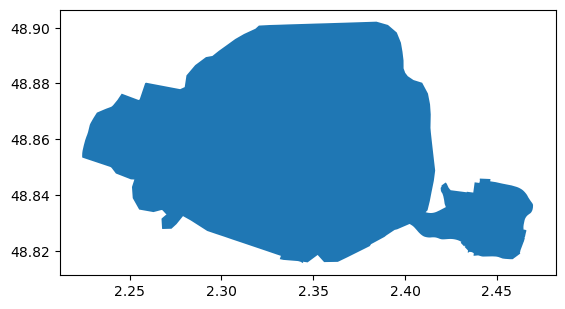

In [5]:
paris_area = unite_polygon(paris_area)

In [6]:
paris_no_green = gpd.read_file('../shapefiles/paris_arrondissement_no_green.geojson')
paris_no_green = paris_no_green.to_crs(epsg=3857)

In [7]:
radius = 1100
alpha = 0.001
points = []
while len(points) != 100:
    points = poisson_disk_sampling(paris_area, radius)
    points = points[points.within(paris_no_green.unary_union)]
    loss = len(points) - 100 
    radius = radius + alpha * loss
    
    print(f'New radius: {radius}, loss: {loss}')

New radius: 1100.002, loss: 2
New radius: 1100.003, loss: 1
New radius: 1100.0069999999998, loss: 4
New radius: 1100.0049999999999, loss: -2
New radius: 1100.013, loss: 8
New radius: 1100.011, loss: -2
New radius: 1100.011, loss: 0


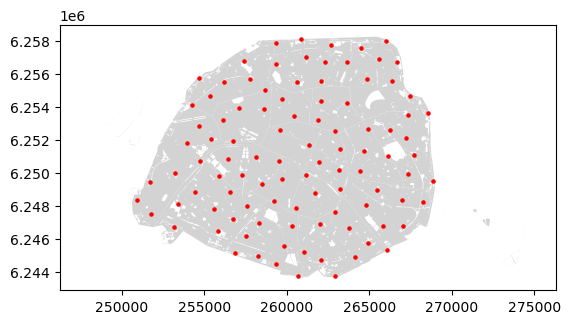

In [8]:
# (Opzionale) Visualizza i punti e il poligono della città
fig, ax = plt.subplots()
gpd.read_file('../shapefiles/paris_arrondissement_no_green.geojson').to_crs(epsg=3857).plot(ax=ax, color='lightgrey')
points.plot(ax=ax, color='red', markersize=5)
plt.show()

In [12]:
points = points.to_crs(epsg=4326)

In [13]:
final_coords = [[point.x, point.y] for point in points.geometry]

In [16]:
with open('../coordinates/coord_par_100.json', 'w') as f:
    json.dump(final_coords, f)